In [79]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [81]:
%%R
library(readr)
library(dplyr)
library(phyloseq)
library(magrittr)
library(ggplot2)
library(rwantshue)
library(DESeq2)
scheme = iwanthue()


Error in library(rwantshue) : there is no package called ‘rwantshue’


In [138]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    otu_table(taxa_are_rows = TRUE)

tax_tab = read_csv("data/tax_table.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    tax_table

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data

tree = phy_tree(ape::read.tree("data/variants.tree"))

ps = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>% 
    prune_samples((sampleSums(.) > 1000)&
                  (sample_data(.)$star == "star"), .) %>%
    subset_taxa(Rank2 == "Proteobacteria")

psnorm = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>% 
    prune_samples((sampleSums(.) > 1000)&
                  (sample_data(.)$star == "star"), .) %>%
    subset_taxa(Rank2 == "Proteobacteria") %>%
    transform_sample_counts(function(x) x / sum(x)) %>%
    transform_sample_counts(function(x) log(x))
        
ps 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3520 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 3520 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3520 tips and 3517 internal nodes ]


In [108]:
%%R
dds = phyloseq_to_deseq2(ps, ~Sample.Type)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(dds), 1, gm_mean)


dds = DESeq2::estimateSizeFactors(dds, geoMeans = geoMeans)
dds = DESeq2::estimateDispersions(dds)
abund = DESeq2::getVarianceStabilizedData(dds)

dds = DESeq2::DESeq(dds, test = "LRT", reduced = ~ 1)

In [109]:
%%R

res = DESeq2::results(dds, cooksCutoff = TRUE)
alpha = 0.05 #previously using 0.1, should this not be 0.05???
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps)[rownames(sigtab), ], "matrix"))
head(sigtab)

                baseMean log2FoldChange     lfcSE     stat       pvalue
Sequence.47   15.7264154      -2.484759 0.7980985 17.38840 5.879441e-04
Sequence.22   24.5172249      -4.165457 1.3092452 17.70881 5.050511e-04
Sequence.316   0.9574075      -5.630930 1.6952556 20.25928 1.499830e-04
Sequence.42   13.2000965      -6.183062 1.9017629 21.37833 8.784792e-05
Sequence.4   322.8831731       5.928824 1.1230232 19.53428 2.119615e-04
                   padj               Rank3          Rank2    Rank1
Sequence.47  0.04315510 Alphaproteobacteria Proteobacteria Bacteria
Sequence.22  0.04315510 Alphaproteobacteria Proteobacteria Bacteria
Sequence.316 0.02592995 Alphaproteobacteria Proteobacteria Bacteria
Sequence.42  0.02592995  Betaproteobacteria Proteobacteria Bacteria
Sequence.4   0.02592995 Gammaproteobacteria Proteobacteria Bacteria
                            Rank7                Rank6              Rank5
Sequence.47                  <NA>                 <NA> Erythrobacteraceae
Sequence.22 

## Quality control for DESeq

In [146]:
%%R
abund_sums = rbind(data.frame(sum = colSums(abund),
                     sample = colnames(abund),
                     type = "DESeq2"),
                   data.frame(sum = rowSums(otu_table(psnorm)),
                     sample = rownames(otu_table(psnorm)),
                     type = "log(x)"))
head(abund_sums)

               sum   sample   type
X8106_PC -20513.19 X8106_PC DESeq2
X8507_CF -19550.69 X8507_CF DESeq2
X8508_TF -20731.69 X8508_TF DESeq2
X8509_G  -20466.20  X8509_G DESeq2
X8510_PC -20609.64 X8510_PC DESeq2
X8528_CF -19911.95 X8528_CF DESeq2


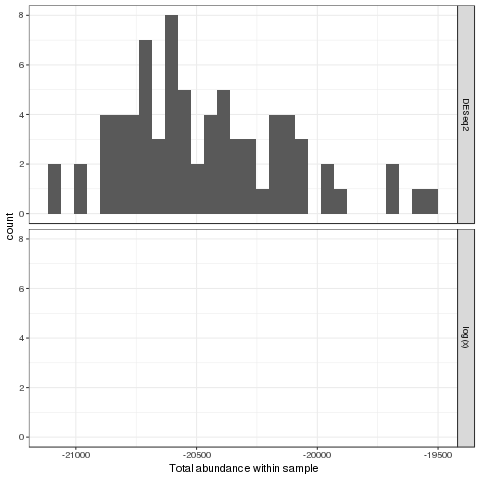

In [140]:
%%R

p = ggplot(abund_sums) + geom_histogram(aes(x = sum))

p = p + facet_grid(type ~ .) + xlab("Total abundance within sample")

p

        0%        10%        20%        30%        40%        50%        60% 
 0.2219759  0.9734706  1.7745692  3.2780098  4.1717780  6.0556661  7.1027947 
       70%        80%        90%       100% 
 8.4340646 10.1500824 11.9858601 17.3195075 


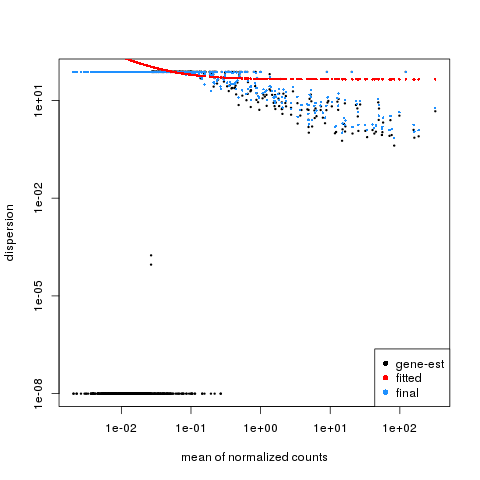

In [99]:
%%R
DESeq2::plotDispEsts(dds)
quantile(DESeq2::sizeFactors(dds), seq(0,1,0.1))

## Back to Analysis

In [22]:
%%R
game_changers = DESeq2::results(dds) %>%
    data.frame %>%
    add_rownames("seq_id") %>%
    arrange(padj) %>%
    filter(padj <= 0.1) %>%
    magrittr::extract2("seq_id")

game_changers

 [1] "Sequence.316" "Sequence.42"  "Sequence.4"   "Sequence.47"  "Sequence.22" 
 [6] "Sequence.11"  "Sequence.129" "Sequence.33"  "Sequence.64"  "Sequence.86" 


In [16]:
%%R
mdf = psmelt(ps) %>% tbl_df

In [58]:
%%R
mdf %>% tbl_df

# A tibble: 264,000 × 19
           OTU    Sample Abundance Sample_number X96.Well.Plate.Location
*        <chr>     <chr>     <int>         <int>                   <chr>
1   Sequence.4 T1EVA8_BP     26847            64                  P1- B6
2  Sequence.48   C606_PC     19044            90                 P1 - H8
3  Sequence.24   C326_TF     18189            68                 P1 - F6
4  Sequence.49   C395_TF     17900            77                 P1 - F7
5  Sequence.54   C607_TF     16216            91                 P1 - A9
6  Sequence.56   X8534_G     16011             6                 P1 - C1
7  Sequence.24   C565_TF     11093            71                 P1 - A7
8  Sequence.44  X8557_TF     10987            27                 P1 - B3
9   Sequence.4 T1EVA2_BP     10684            58                 P1 - F5
10 Sequence.33    CF1_CF      8519             1                P1 - E12
# ... with 263,990 more rows, and 14 more variables: Sample.Amount <chr>,
#   Genus.Species <chr>, 

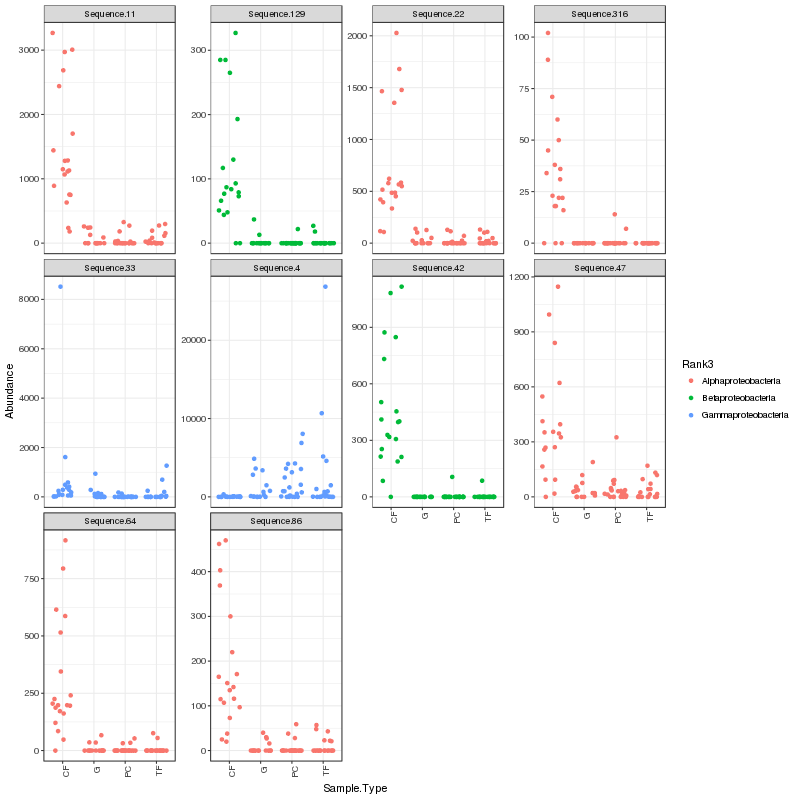

In [72]:
%%R -h 800 -w 800
d.plot = mdf %>% filter(OTU %in% game_changers)
d.plot$OTU = factor(d.plot$OTU)

p = ggplot(d.plot, aes(x = Sample.Type, y = Abundance, color = Rank3))

p = p + facet_wrap(~ OTU, scales = "free_y")#,labeller = as_labeller(Rank6))

p = p + geom_point(position = position_jitter(h = 0, w = 0.35))

p = p + theme(axis.text.x = element_text(angle = 90, hjust = 1))

p

In [71]:
!bioawk -c fastx '{if ( $name == "Sequence.42") print $seq}' data/EC_fasta.fa 

CCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTGTGCAAGACCGATGTGAAATCCCCGAGCTTAACTTGGGAATTGCATTGGTGACTGCACGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGG
